In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

<IPython.core.display.Javascript object>

In [1]:
import os
from pathlib import Path
import pickle

home = str(Path.home())
data_path = os.path.join(home, "GA_generation", "Data", "trajs_dict_ga_14_cleaned.pkl")

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import pandas as pd

from airtraj import trajectories as traj
from traffic.data import airports
from traffic.drawing import countries
import traffic.core.geodesy as geo

with open(data_path, "rb") as handle:
    trajs_dict = pickle.load(handle)

GA = traj.generate_Traffic_from_trajs_dict(trajs_dict).assign_id().eval(desc="")
# Putting timestamps in the same fromat as traffic object
GA.data.timestamp = pd.to_datetime(GA.data.timestamp).dt.tz_localize("UTC")

<ipython-input-1-2b4120a4bd27>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
100%|██████████| 646/646 [00:02<00:00, 279.75it/s]


  0%|          | 0/646 [00:00<?, ?it/s]

Preprocessing à faire : 
- Normaliser le début des trajectoires (par exemple, le premier point du premier aligned on ils)
- Séparer les plusieurs go-arounds s'il y en a 
- Enlever les holding patterns
- Enlever les go-arounds vers une autre piste
- Ne sélectionner les go-arounds que d'un seul et même côté
- Un go around = de la fin de la piste jusqu'à l'ils (on ne s'occupe pas des early ga) 
- Trouver un moyen de resample pour avoir le même nombre de points : Comme les go-arounds sont tous des tailles et durées différentes, on va peut être devoir dropper la composante temporelle

# Selecting the right GA

In [4]:
# More than 1 ga
def count_GA(f):
    nb_ils = len(f.aligned_on_ils(airports["LSZH"]))
    if nb_ils > 2:
        return f
    else:
        return None


GAs = GA.iterate_lazy().pipe(count_GA).eval(desc="")

  0%|          | 0/646 [00:00<?, ?it/s]

airports @ourairports.com:   0%|          | 0/9561 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

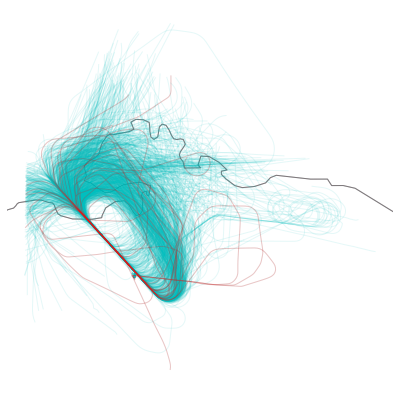

<IPython.core.display.Javascript object>

In [5]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA.plot(ax, alpha=0.1, color="c")
    GAs.plot(ax, alpha=0.2, color="r")

In [6]:
dict_ils = {}
for f in tqdm(GA):
    ils = f.aligned_on_ils("LSZH")
    starts = []
    for seg in ils:
        if seg.max("ILS") == "14":
            starts.append(
                seg.stop
            )  # We take a go around from runway threshold to runway threshold
    dict_ils[f.flight_id] = starts

  0%|          | 0/646 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [7]:
from collections import Counter

Counter(list(map(len, dict_ils.values())))

Counter({2: 631, 0: 2, 1: 8, 3: 5})

<IPython.core.display.Javascript object>

In [8]:
# Extracting Go around for flights with only one go around runway 14
def first_ga(f):
    if f.flight_id in dict_ils.keys():
        if len(dict_ils[f.flight_id]) == 2:
            return f.between(dict_ils[f.flight_id][0], dict_ils[f.flight_id][1])
        else:
            return None
    else:
        return None


GA1 = GA.iterate_lazy().pipe(first_ga).resample("1s").eval(desc="", max_workers=10)

  0%|          | 0/646 [00:00<?, ?it/s]

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

<IPython.core.display.Javascript object>

In [9]:
# Récupération des coordonnées du seuil de piste 14
a = airports["LSZH"].runways.data[airports["LSZH"].runways.data.name == "14"]
latlonbear14 = np.round(
    [a.latitude.values[0], a.longitude.values[0], a.bearing.values[0]], 3
)
latlonbear14

# Créatoin du seuil
set0 = geo.destination(latlonbear14[0], latlonbear14[1], latlonbear14[2], 3300)
set1 = geo.destination(set0[0], set0[1], set0[2] + 90, 500)  # point A du seuil
set2 = geo.destination(set0[0], set0[1], set0[2] - 90, 500)  # point B du seuil
set3 = geo.destination(set2[0], set2[1], latlonbear14[2], 600)  # Epaisseur
set4 = geo.destination(set1[0], set1[1], latlonbear14[2], 600)  # Epaisseur

# Forme en bout de piste 14
from shapely.geometry import Polygon

lat_point_list = [set1[0], set2[0], set3[0], set4[0]]
lon_point_list = [set1[1], set2[1], set3[1], set4[1]]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))

notinend = []
inend = []
clipnotin = []
clipin = []
for f in tqdm(GA1):
    if not f.intersects(polygon_geom):
        notinend.append(f.flight_id)
    else:
        inend.append(f.flight_id)

for f in tqdm(GA1):
    if f.clip(polygon_geom) is None:
        clipnotin.append(f.flight_id)
    else:
        clipin.append(f.flight_id)

  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/631 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [10]:
# Quels sont les vols qui ont un intersect = True, mais un clip = False
inter = list(set(clipnotin) & set(inend))
len(inter)

from ipyleaflet import Polygon as Popo

m = GA1[inter].map_leaflet(zoom=12)

coords = list((lat, lon) for (lon, lat, *_) in polygon_geom.exterior.coords)
shape = Popo(locations=coords, color="red")
m.add_layer(shape)

m

Map(center=[47.57341960673328, 8.495755260552817], controls=(ZoomControl(options=['position', 'zoom_in_text', …

<IPython.core.display.Javascript object>

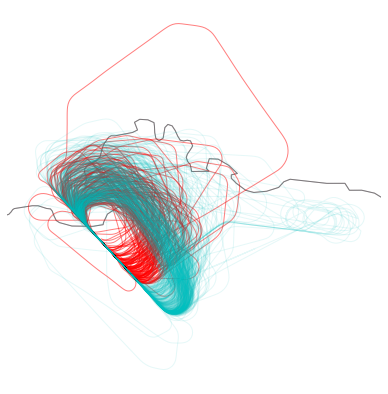

<IPython.core.display.Javascript object>

In [11]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA1[notinend].plot(ax, alpha=0.5, color="r")
    GA1[inend].plot(ax, alpha=0.1, color="c")

In [12]:
def from_end_runway(flight):
    g = flight.clip(polygon_geom)
    if g is None:
        return None
    return flight.after(g.start)


GA1_norm = GA1.iterate_lazy().pipe(from_end_runway).eval(desc="")
GA1_norm

  0%|          | 0/631 [00:00<?, ?it/s]

count
flight_id         
FLJ602_415    2990
CAZ802_409    2186
SWR963_410    2097
SWR109R_637   1699
SIA346_632    1552
EZY42PU_332   1507
BAW14R_358    1378
UAE2MJ_348    1370
VLG21QR_166   1289
EZY84MN_412   1279

<IPython.core.display.Javascript object>

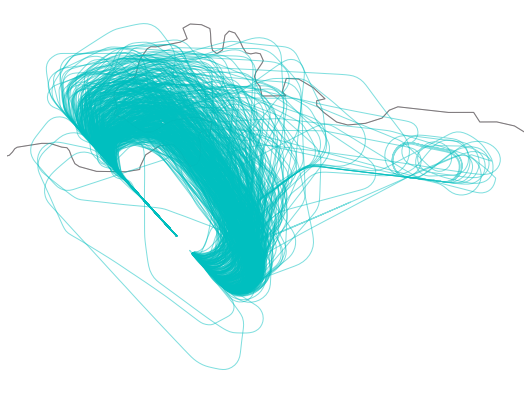

<IPython.core.display.Javascript object>

In [13]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA1_norm.plot(ax, alpha=0.5, color="c")

In [14]:
from traffic.data import navaids


def til_FAF(flight):
    g = flight.query("distance < (1.5*1.850)")
    if g is None:
        return None
    return flight.before(g.stop)


GA1_norm = GA1_norm.distance(navaids["OSNEM"]).pipe(til_FAF).eval(desc="")
GA1_norm

  0%|          | 0/486 [00:00<?, ?it/s]

count
flight_id         
FLJ602_415    2868
CAZ802_409    2058
SWR963_410    1971
SWR109R_637   1583
SIA346_632    1418
EZY42PU_332   1371
BAW14R_358    1251
UAE2MJ_348    1247
VLG21QR_166   1173
EZY84MN_412   1161

<IPython.core.display.Javascript object>

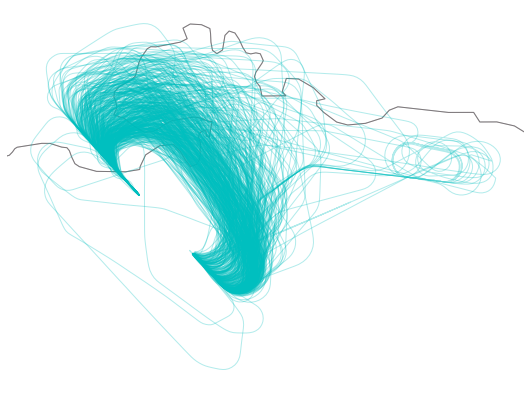

<IPython.core.display.Javascript object>

In [15]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA1_norm.plot(ax, alpha=0.3, color="c")

In [16]:
def crop_holdings(flight):
    g = flight.query("distance < 2")
    if g is None:
        return flight
    else:
        return None


GA1_norm = GA1_norm.distance(navaids["AMIKI"]).pipe(crop_holdings).eval(desc="")
GA1_norm

  0%|          | 0/486 [00:00<?, ?it/s]

count
flight_id         
BAW14R_358    1251
SWR771_431    1099
UAL134_054    1069
None_322      1065
SWR68L_480    1063
SWR89T_309    1033
HBKPN_611     1027
SWR1069_237   1021
IBE3464_456    987
EWG9MT_148     985

<IPython.core.display.Javascript object>

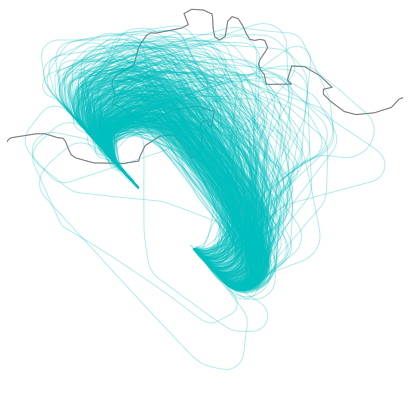

<IPython.core.display.Javascript object>

In [17]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA1_norm.plot(ax, alpha=0.3, color="c")

In [18]:
GA1_norm.map_leaflet()

Map(center=[47.57466185905321, 8.540876334453626], controls=(ZoomControl(options=['position', 'zoom_in_text', …

<IPython.core.display.Javascript object>

In [19]:
# drop GA on wrong side
GA1_norm = GA1_norm.query(
    "flight_id not in ['SWR74A_164', 'OMA153_038', 'AUI471_234', 'SWR202A_173', 'SWR1069_237']"
)

<IPython.core.display.Javascript object>

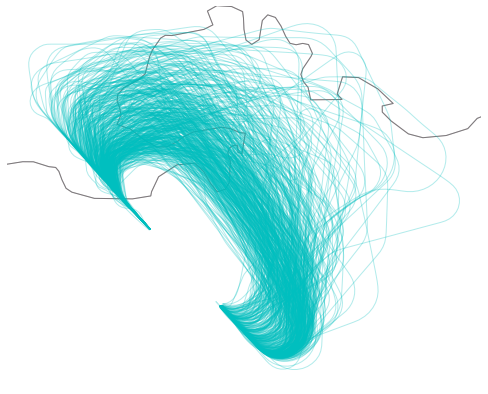

<IPython.core.display.Javascript object>

In [20]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA1_norm.plot(ax, alpha=0.3, color="c")

In [21]:
long = [
    flight.flight_id for flight in GA1_norm if (flight.duration.total_seconds() > 800)
]
print(len(long))

GA1_norm = GA1_norm.query("flight_id not in {}".format(long))
# GA1_norm[long].map_leaflet(zoom=9)

59


<IPython.core.display.Javascript object>

In [22]:
GA1_norm

count
flight_id         
SWR287A_167    795
SWR1327_617    794
SWR39_335      794
UAE2MJ_136     789
VLG73DB_453    789
SWR2561_562    785
SWR184H_465    783
SIA346_053     782
AFR19RF_552    781
SWR819_128     781

<IPython.core.display.Javascript object>

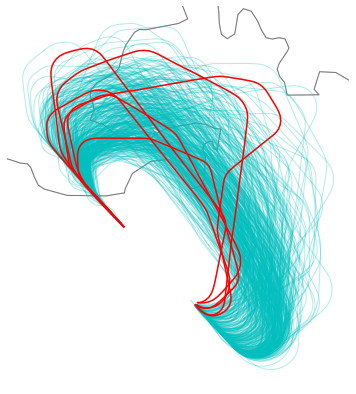

<IPython.core.display.Javascript object>

In [23]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA1_norm.plot(ax, alpha=0.3, color="c")
    GA1_norm[295].plot(ax, alpha=1, color="r")
    GA1_norm[0].plot(ax, alpha=1, color="r")
    GA1_norm[350].plot(ax, alpha=1, color="r")
    GA1_norm[214].plot(ax, alpha=1, color="r")
    GA1_norm[202].plot(ax, alpha=1, color="r")
    GA1_norm[382].plot(ax, alpha=1, color="r")

In [24]:
# drop flight that mess up the resampling
GA1_norm = GA1_norm.query(
    "flight_id not in {}".format(
        [
            GA1_norm[0].flight_id,
            GA1_norm[350].flight_id,
            GA1_norm[295].flight_id,
            GA1_norm[214].flight_id,
            GA1_norm[202].flight_id,
            GA1_norm[382].flight_id,
        ]
    )
)

<IPython.core.display.Javascript object>

In [25]:
GA1_norm.to_parquet("Data/Go_Arounds_clean.parquet")

<IPython.core.display.Javascript object>

# Data Preprocessing : finding the median trajectory

Pour trouver la trajectoire médiane, on resample à une granularité faible. Une fois cette trajectoire trouvée, on la resample au nombre de points désiré afin de resampler toute la base.  

Le fait d'avoir un trajectoire exterieur pour référence va faire en sorte d'avoir des trajectoires resampled plus smooth, mais au risque d'y avoir des points mal placés, alors qu'une trajectoire intérieure va nous donner des trajectoires resamplé moins smooth, mais avec moins de points mal placés

In [26]:
# plus court
durations = []
for f in GA1_norm:
    durations.append(f.duration)

shorter = np.argmin(durations)
longer = np.argmax(durations)

print("shortest :", shorter)
print("longest :", longer)

shortest : 97
longest : 302


<IPython.core.display.Javascript object>

In [27]:
import pyproj
from traffic.core import Traffic

swiss = pyproj.Proj(init="EPSG:21781")

data = GA1_norm.resample(200).compute_xy(projection=swiss).eval(desc="")

features = ["x", "y"]
raw_data = np.stack(list(f.data[features].values.ravel() for f in data))

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


  0%|          | 0/407 [00:00<?, ?it/s]

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

<IPython.core.display.Javascript object>

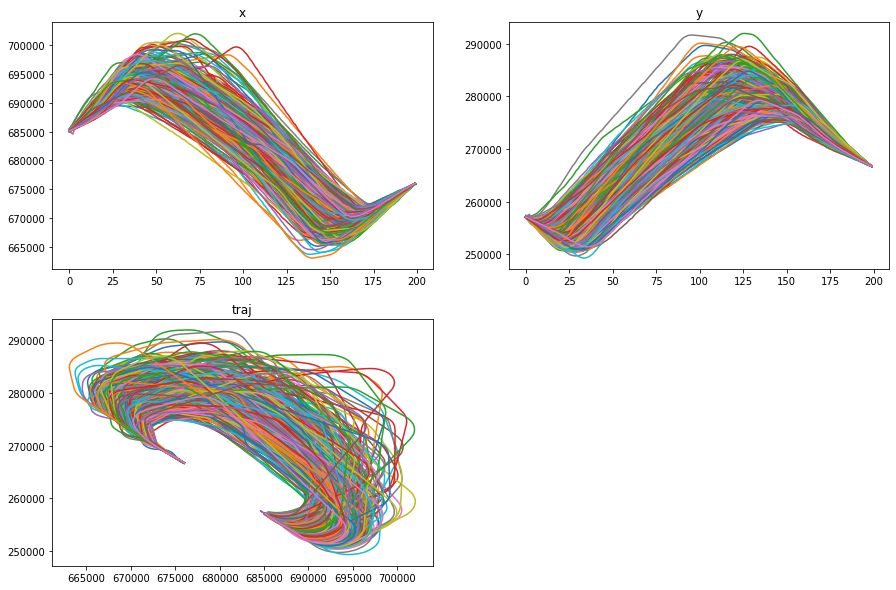

<IPython.core.display.Javascript object>

In [28]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(raw_data[:, ::2].T)
plt.title("x")

plt.subplot(222)
plt.plot(raw_data[:, 1::2].T)
plt.title("y")

plt.subplot(223)
plt.plot(raw_data[:, ::2].T, raw_data[:, 1::2].T)
plt.title("traj")

plt.show()

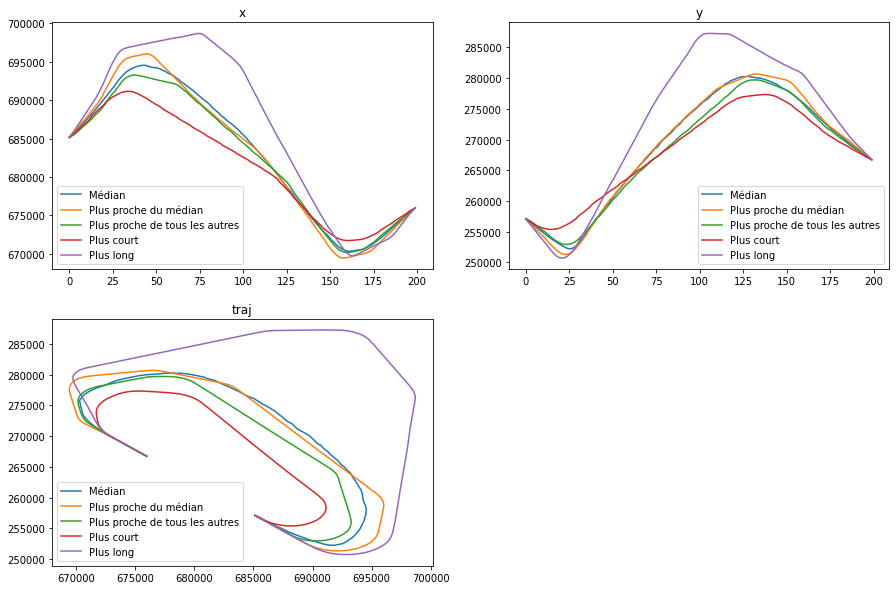

<IPython.core.display.Javascript object>

In [29]:
mean = np.median(raw_data, axis=0)

dist = []
for i in range(raw_data.shape[0]):
    dist.append(np.linalg.norm(np.median(raw_data, axis=0) - raw_data[i, :]))
centroid = np.argmin(dist)

every_dist = np.zeros((raw_data.shape[0], raw_data.shape[0]))
for i in range(raw_data.shape[0]):
    base = raw_data[i, :]
    for j in range(raw_data.shape[0]):
        every_dist[i, j] = np.linalg.norm(base - raw_data[j, :])
closest = np.argmin(np.median(every_dist, axis=0))

plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(mean[::2].T)
plt.plot(raw_data[centroid, ::2].T)
plt.plot(raw_data[closest, ::2].T)
plt.plot(raw_data[shorter, ::2].T)
plt.plot(raw_data[longer, ::2].T)
plt.legend(
    [
        "Médian",
        "Plus proche du médian",
        "Plus proche de tous les autres",
        "Plus court",
        "Plus long",
    ]
)
plt.title("x")

plt.subplot(222)
plt.plot(mean[1::2].T)
plt.plot(raw_data[centroid, 1::2].T)
plt.plot(raw_data[closest, 1::2].T)
plt.plot(raw_data[shorter, 1::2].T)
plt.plot(raw_data[longer, 1::2].T)
plt.legend(
    [
        "Médian",
        "Plus proche du médian",
        "Plus proche de tous les autres",
        "Plus court",
        "Plus long",
    ]
)
plt.title("y")

plt.subplot(223)
plt.plot(mean[::2].T, mean[1::2].T)
plt.plot(raw_data[centroid, ::2].T, raw_data[centroid, 1::2].T)
plt.plot(raw_data[closest, ::2].T, raw_data[closest, 1::2].T)
plt.plot(raw_data[shorter, ::2].T, raw_data[shorter, 1::2].T)
plt.plot(raw_data[longer, ::2].T, raw_data[longer, 1::2].T)
plt.legend(
    [
        "Médian",
        "Plus proche du médian",
        "Plus proche de tous les autres",
        "Plus court",
        "Plus long",
    ]
)
plt.title("traj")

plt.show()

In [30]:
print("médian :", closest)
print("Plus court :", shorter)
print("Plus long :", longer)

médian : 330
Plus court : 97
Plus long : 302


<IPython.core.display.Javascript object>

# Resamplig according to the median trajectory

In [31]:
def perp_to_ref(ref_traj_x, ref_traj_y, ref_traj_alt):

    """
    Inputs : 
    ref_traj_x : array of x coordinates of the reference trajectory
    ref_traj_y : array of y coordinates of the reference trajectory
    ref_traj_alt : array of the altitude of the reference trajectory
    
    Outputs : 
    perpendiculars : slope, intersect, and coordinates of the crossing point between perpendicular and ref traj
    """
    perpendiculars = []

    for i in range(len(ref_traj_x)):

        # Calculus of the perpendicular
        slope = (ref_traj_y[i] - ref_traj_y[i - 1]) / (
            ref_traj_x[i] - ref_traj_x[i - 1]
        )  # works too for i = 0
        p_slope = -1.0 / slope
        p_intersect = ref_traj_y[i] - p_slope * ref_traj_x[i]
        perpendiculars.append(
            (p_slope, p_intersect, ref_traj_x[i], ref_traj_y[i], ref_traj_alt[i])
        )

    return perpendiculars

<IPython.core.display.Javascript object>

In [32]:
def distances_to_line1(X0, Y0, m, k):
    dist_horiz = np.abs(k + m * X0 - Y0) / np.sqrt(1 + m ** 2)
    return dist_horiz

def sampling_from_ref1(perpendiculars, to_sample_x, to_sample_y):

    """
    Inputs : 
    perpendiculars : output from perp_to_ref
    to_sample_x : array of x coordinates of the trajectory to sample
    to_sample_y : array of y coordinates of the trajectory to sample
    
    Outputs : 
    argmin : index of sampled points within the traj to sample
    """
    
    argmin = []

    for i in range(len(perpendiculars)):
        
        p_slope = perpendiculars[i][0]
        p_intersect = perpendiculars[i][1]
        ref_traj_x = perpendiculars[i][2]
        ref_traj_y = perpendiculars[i][3]

        if len(argmin) == 0:
            remain_a = to_sample_x
            remain_b = to_sample_y
            offset_argmin = 0
            argmin.append(0)

        else:
            # On fait +1 pour éviter à avoir à répéter plusieur fois le même point
            
            remain_a = to_sample_x[(argmin[-1] + 1) :(argmin[-1] + 1) + 200]
            remain_b = to_sample_y[(argmin[-1] + 1) :(argmin[-1] + 1) + 200]
            offset_argmin = argmin[-1] + 1
        
            #distance to line in 2D
            dists_to_line = distances_to_line1(remain_a, remain_b, p_slope, p_intersect)

            #We take the closest points to perpendicular
            candidates = np.argsort(dists_to_line)[:10]
            print("candidates :", candidates)
            

            #If we have some spurious points in the candidates
            if (candidates.max() - candidates.min()) > 20:
                #we take the point with the min distance to perpendicular among the closest to the ref point
                #in term of advancement in the trajectory
                right_point = candidates[candidates < candidates.mean()][0]
                
            #when we only have spurious points within the selected batch
            #That much because sometimes perpendiculars are crossing the traj before the previously selected point
            #So the algorithm detect the batch of closests points way too far from the ref
            #so we take the next one
            elif candidates.min() > 140 : 
                right_point = 0
            
            else : 
                right_point = candidates[0]

            argmin.append(right_point + offset_argmin)
            print("right point :", right_point)
            print("argmin :", argmin[-1])
            print("")

    return argmin


<IPython.core.display.Javascript object>

Il faut faire attention à plusieurs choses : 
- Si les perpendiculaires suivantes croisent la trajectoires avant les perpendiculaires précédentes, on a des problèmes à cause de "remain" dans l'algorithme. On préfèrera enlever ces cas de figure de l'étude.
- Il faut faire attentions à la condition "candidates.min() > 140". Elle permet de s'assurer que le point sélectionné ne soit pas trop loin du point précédent. Néanmoins, selon le nombre de points samplés, il se peut que la distance entre deux points consécutifs peut être grand. On prendra donc des valeurs relaivement grandes pour un sampling avec peu de points, et faibles pour un sampling avec beaucoup de points. 

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)


142


/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)


candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 15

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 33

candidates : [36 35 37 34 38 33 32 39 31 40]
right point : 36
argmin : 70

candidates : [42 41 43 40 44 39 45 38 46 37]
right point : 42
argmin : 113

candidates : [44 45 43 46 42 47 41 48 40 49]
right point : 44
argmin : 158

candidates : [32 33 31 34 30 35 29 36 28 37]
right point : 32
argmin : 191

candidates : [21 20 22 19 23 18 17 24 16 25]
right point : 21
argmin : 213

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 228

candidates : [12 13 11 14 10 15  9 16 17  8]
right point : 12
argmin : 241

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 256

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 271

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 284

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 299

candidates : [1

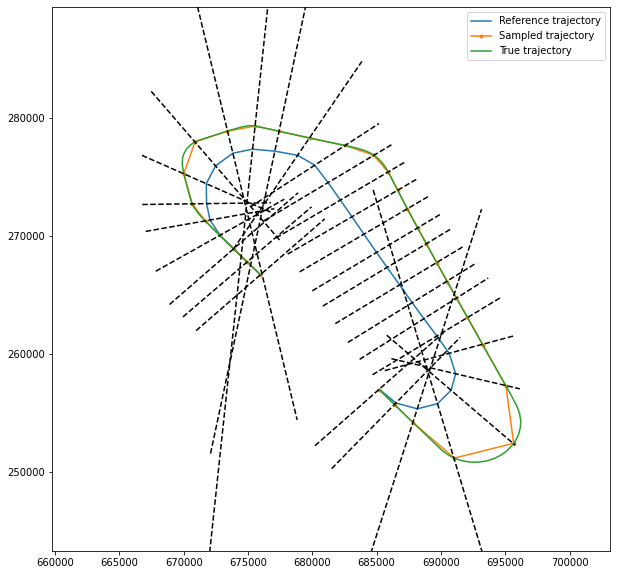

<IPython.core.display.Javascript object>

In [38]:
# take the shrotest traj (97)
nb_points = 30
x_centroid, y_centroid, alt_centroid = (
    data[97].resample(nb_points).data.x.values,
    data[97].resample(nb_points).data.y.values,
    data[97].resample(nb_points).data.altitude.values,
)

sel = np.random.randint(406)
# sel = "EWG5FW_205"
# sel = 213
print(sel)
a = GA1_norm[sel].resample("1s").compute_xy(swiss).data.x.values
b = GA1_norm[sel].resample("1s").compute_xy(swiss).data.y.values
c = GA1_norm[sel].resample("1s").data.altitude.values

perpendiculars = perp_to_ref(x_centroid, y_centroid, alt_centroid)
# argmin = sampling_from_ref(perpendiculars, a, b, c, lbda=0.8)
argmin = sampling_from_ref1(perpendiculars, a, b)


plt.figure(figsize=(10, 10))

plt.plot(x_centroid.T, y_centroid.T)
plt.plot(a[argmin], b[argmin], marker=".")
plt.plot(a, b)
plt.legend(["Reference trajectory", "Sampled trajectory", "True trajectory"])

for ele in perpendiculars:
    y1 = ele[0] * (ele[2] - 5000) + ele[1]
    y2 = ele[0] * (ele[2] + 5000) + ele[1]

    plt.plot(
        [(ele[2] - 5000), (ele[2] + 5000)], [y1, y2], color="black", linestyle="--",
    )

plt.xlim(x_centroid.min() - 12000, x_centroid.max() + 12000)
plt.ylim(y_centroid.min() - 12000, y_centroid.max() + 12000)

plt.show()

In [34]:
# resampling accoring to the previous method

nb_points = 30

from traffic.core import Flight

GA1_norm_resampled = (
    GA1_norm.resample("1s").compute_xy(swiss).eval(desc="resampling 1s")
)
x_centroid, y_centroid, alt_centroid = (
    data[97].resample(nb_points).data.x.values,
    data[97].resample(nb_points).data.y.values,
    data[97].resample(nb_points).data.altitude.values,
)

t_GA_resampled_data = []
perpendiculars = perp_to_ref(x_centroid, y_centroid, alt_centroid)
pd.DataFrame(perpendiculars, columns=["m", "p", "x", "y", "z"]).to_parquet(
    "/cluster/home/kruu/GA_generation/Data/Normals_sampling.parquet"
)

for f in tqdm(GA1_norm_resampled):

    a = f.data.x.values
    b = f.data.y.values

    argmin = sampling_from_ref1(perpendiculars, a, b)
    ts_points = f.data.iloc[argmin, :].timestamp

    # Reconstruct flight
    new_f = []
    for el in ts_points:
        new_f.append(f.at(el))
    new_f_df = pd.DataFrame(new_f)
    new_f_df.reset_index(level=0, inplace=True)
    new_f_df = new_f_df.rename(columns={"index": "timestamp"})

    t_GA_resampled_data.append(new_f_df)

t_GA_resampled = Traffic(pd.concat(t_GA_resampled_data))
t_GA_resampled.to_parquet("/cluster/home/kruu/GA_generation/Data/GA_resampled.parquet")

resampling 1s:   0%|          | 0/407 [00:00<?, ?it/s]

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))


  0%|          | 0/407 [00:00<?, ?it/s]

candidates : [ 20 188 187  19  21 189 186  18  22 190]
right point : 20
argmin : 21

candidates : [ 17 189 188  18 190  16 187  19 191 186]
right point : 17
argmin : 39

candidates : [30 29 31 28 32 27 33 26 34 25]
right point : 30
argmin : 70

candidates : [33 32 34 35 31 36 30 37 29 38]
right point : 33
argmin : 104

candidates : [32 31 33 30 34 29 35 28 36 27]
right point : 32
argmin : 137

candidates : [34 33 35 32 36 31 37 30 29 38]
right point : 34
argmin : 172

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 195

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 210

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 224

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 239

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 254

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 267

candidates : [14 13 15 12 16 11 17 10 18 19]
right point : 14
argmin : 

candidates : [ 14 178 177  13  15 179 176  12  16 180]
right point : 14
argmin : 15

candidates : [17 16 18 15 19 14 13 20 12 21]
right point : 17
argmin : 33

candidates : [23 22 24 21 20 25 19 26 18 27]
right point : 23
argmin : 57

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 82

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 108

candidates : [33 32 34 31 35 30 36 29 37 28]
right point : 33
argmin : 142

candidates : [31 30 32 29 33 28 34 27 35 26]
right point : 31
argmin : 174

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 190

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 203

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 218

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 234

candidates : [12 11 13 10 14  9 15  8  7 16]
right point : 12
argmin : 247

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 261

candid

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 23

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 43

candidates : [35 36 34 37 33 38 32 39 31 40]
right point : 35
argmin : 79

candidates : [40 41 39 42 38 43 37 36 44 35]
right point : 40
argmin : 120

candidates : [35 34 36 33 37 32 38 31 39 30]
right point : 35
argmin : 156

candidates : [32 31 33 30 34 29 35 28 36 27]
right point : 32
argmin : 189

candidates : [30 31 29 32 28 33 27 34 26 35]
right point : 30
argmin : 220

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 239

candidates : [12 13 11 14 10  9 15  8 16  7]
right point : 12
argmin : 252

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 266

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 280

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 292

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 306

candidates : [1

candidates : [84 14 83 15 85 13 82 86 16 12]
right point : 14
argmin : 15

candidates : [79 15 14 78 80 16 77 81 13 76]
right point : 15
argmin : 31

candidates : [ 12 131 132 130 133 129 134 128 135 127]
right point : 12
argmin : 44

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 56

candidates : [11 10 12  9 13  8 14 15  7 16]
right point : 11
argmin : 68

candidates : [14 15 13 16 12 17 18 11 19 10]
right point : 14
argmin : 83

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 99

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 116

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 132

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 148

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 165

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 179

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 196

candidate

candidates : [ 24 196 195  25  23 197 194  26  22 198]
right point : 24
argmin : 25

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 48

candidates : [36 37 35 34 38 33 39 32 40 31]
right point : 36
argmin : 85

candidates : [30 31 29 32 28 33 27 34 26 35]
right point : 30
argmin : 116

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 143

candidates : [26 27 25 28 24 29 23 30 22 31]
right point : 26
argmin : 170

candidates : [25 26 24 27 23 28 22 29 21 30]
right point : 25
argmin : 196

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 213

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 225

candidates : [12 13 11 14 10  9 15  8 16  7]
right point : 12
argmin : 238

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 251

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 262

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 276

candi

candidates : [79 14 78 15 80 77 13 16 81 76]
right point : 14
argmin : 15

candidates : [ 99  98  13  14 100  97  15  12 101  96]
right point : 13
argmin : 29

candidates : [184   9 183 185 182   8 186  10 181 187]
right point : 9
argmin : 39

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 47

candidates : [ 9  8 10  7 11  6 12  5  4 13]
right point : 9
argmin : 57

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 71

candidates : [19 18 17 20 16 21 15 22 14 23]
right point : 19
argmin : 91

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 107

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 120

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 134

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 149

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 161

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 176

ca

candidates : [14 15 13 16 12 17 11 10 18  9]
right point : 14
argmin : 15

candidates : [16 17 15 18 14 19 13 20 12 11]
right point : 16
argmin : 32

candidates : [34 35 33 36 32 31 37 30 38 29]
right point : 34
argmin : 67

candidates : [41 42 40 43 39 44 38 45 37 46]
right point : 41
argmin : 109

candidates : [47 46 48 45 49 44 50 43 51 42]
right point : 47
argmin : 157

candidates : [57 58 56 59 55 60 54 61 53 62]
right point : 57
argmin : 215

candidates : [34 35 33 36 32 37 31 38 30 39]
right point : 34
argmin : 250

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 268

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 281

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 296

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 312

candidates : [14 13 15 12 16 11 17 18 10 19]
right point : 14
argmin : 327

candidates : [16 17 15 18 14 19 20 13 21 12]
right point : 16
argmin : 344

candidates : [1

candidates : [117  13  14 118 116  12 119  15 115 120]
right point : 13
argmin : 14

candidates : [129  15 130 128  14 131 127  16 132 126]
right point : 15
argmin : 30

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 47

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 65

candidates : [18 19 17 20 16 21 15 22 14 23]
right point : 18
argmin : 84

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 107

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 128

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 144

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 158

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 174

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 190

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 203

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 21

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 14

candidates : [17 16 18 15 19 14 20 21 13 22]
right point : 17
argmin : 32

candidates : [35 36 34 37 33 38 32 31 39 30]
right point : 35
argmin : 68

candidates : [40 41 39 42 38 43 37 44 36 45]
right point : 40
argmin : 109

candidates : [35 36 34 37 38 33 39 32 40 31]
right point : 35
argmin : 145

candidates : [34 35 33 36 32 37 31 38 30 39]
right point : 34
argmin : 180

candidates : [32 31 33 30 34 29 35 28 36 27]
right point : 32
argmin : 213

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 232

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 245

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 259

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 274

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 286

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 301

candidates : [1

candidates : [127  16 128  17 126  15 129 125  18  14]
right point : 16
argmin : 17

candidates : [126 125  18  19 127 124  17 123 128  20]
right point : 18
argmin : 36

candidates : [ 22  21  23  20  24  19 199  25 198  18]
right point : 22
argmin : 59

candidates : [22 23 21 24 20 25 26 19 27 18]
right point : 22
argmin : 82

candidates : [21 22 20 23 19 24 18 25 17 26]
right point : 21
argmin : 104

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 124

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 142

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 160

candidates : [16 15 17 14 13 18 12 19 11 20]
right point : 16
argmin : 177

candidates : [16 17 15 18 14 13 19 12 20 11]
right point : 16
argmin : 194

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 211

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 226

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17


candidates : [184  13 185  12 183 186  14  11 182 187]
right point : 13
argmin : 14

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 30

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 56

candidates : [29 28 30 27 31 26 32 25 33 24]
right point : 29
argmin : 86

candidates : [32 33 31 34 30 35 29 36 28 37]
right point : 32
argmin : 119

candidates : [36 37 35 38 34 39 33 40 32 41]
right point : 36
argmin : 156

candidates : [28 29 27 30 26 31 25 32 24 33]
right point : 28
argmin : 185

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 203

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 217

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 233

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 250

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 263

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 280

candid

candidates : [193  13  12  14 194 192  11  15 191 195]
right point : 13
argmin : 14

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 30

candidates : [32 31 33 30 29 34 28 35 27 36]
right point : 32
argmin : 63

candidates : [34 33 35 32 36 31 37 30 38 29]
right point : 34
argmin : 98

candidates : [33 34 32 35 31 36 30 37 29 38]
right point : 33
argmin : 132

candidates : [34 35 33 36 32 37 31 38 30 39]
right point : 34
argmin : 167

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 194

candidates : [14 13 15 12 16 11 17 10 18 19]
right point : 14
argmin : 209

candidates : [11 12 10 13  9 14 15  8 16  7]
right point : 11
argmin : 221

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 235

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 249

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 261

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 276

candid

candidates : [ 17  18  16  19  15  20  14  21  13 199]
right point : 17
argmin : 18

candidates : [18 17 19 16 20 15 21 14 13 22]
right point : 18
argmin : 37

candidates : [32 33 31 34 30 35 29 36 28 27]
right point : 32
argmin : 70

candidates : [39 40 38 41 37 42 36 43 35 44]
right point : 39
argmin : 110

candidates : [37 36 38 35 39 34 40 33 41 32]
right point : 37
argmin : 148

candidates : [35 36 34 37 33 38 32 39 31 40]
right point : 35
argmin : 184

candidates : [24 23 25 22 26 21 27 20 28 19]
right point : 24
argmin : 209

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 225

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 239

candidates : [14 13 15 16 12 17 11 18 10 19]
right point : 14
argmin : 254

candidates : [13 14 15 12 16 11 17 18 10 19]
right point : 13
argmin : 268

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 282

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 298

candi

candidates : [ 17 150 151  16  18 149 152  15  19 148]
right point : 17
argmin : 18

candidates : [160  17 159  18 161 158  16 162 157  19]
right point : 17
argmin : 36

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 58

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 81

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 106

candidates : [28 27 29 26 30 25 31 24 32 23]
right point : 28
argmin : 135

candidates : [23 22 24 21 20 25 19 26 18 27]
right point : 23
argmin : 159

candidates : [16 15 17 14 18 13 19 20 12 21]
right point : 16
argmin : 176

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 191

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 208

candidates : [17 16 18 15 14 19 13 20 12 21]
right point : 17
argmin : 226

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 240

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 2

candidates : [22 23 21 20 24 19 25 18 26 17]
right point : 22
argmin : 23

candidates : [190  21 191  20 189  22  19 192 188  23]
right point : 21
argmin : 45

candidates : [ 40  41 199  39  42 198 197  38  43 196]
right point : 40
argmin : 86

candidates : [44 43 45 42 46 41 47 40 48 49]
right point : 44
argmin : 131

candidates : [48 47 46 49 45 50 44 51 43 52]
right point : 48
argmin : 180

candidates : [23 24 22 25 21 26 20 19 27 18]
right point : 23
argmin : 204

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 221

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 238

candidates : [16 15 17 14 18 19 13 20 12 21]
right point : 16
argmin : 255

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 273

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 290

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 305

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 23

candidates : [20 21 19 22 18 23 17 24 16 25]
right point : 20
argmin : 44

candidates : [41 42 40 43 39 38 44 37 45 36]
right point : 41
argmin : 86

candidates : [49 48 50 47 51 46 52 45 53 44]
right point : 49
argmin : 136

candidates : [29 30 28 31 27 32 26 33 25 34]
right point : 29
argmin : 166

candidates : [27 26 28 29 25 30 24 31 23 32]
right point : 27
argmin : 194

candidates : [26 27 25 28 24 29 23 30 22 31]
right point : 26
argmin : 221

candidates : [20 19 21 18 22 17 16 23 15 24]
right point : 20
argmin : 242

candidates : [14 15 13 16 12 17 11 10 18  9]
right point : 14
argmin : 257

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 272

candidates : [14 15 13 16 12 17 11 18 10  9]
right point : 14
argmin : 287

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 300

candidates : [14 13 15 12 16 11 17 18 10 19]
right point : 14
argmin : 315

candidates : [1

candidates : [21 20 22 19 23 24 18 25 17 26]
right point : 21
argmin : 646

candidates : [20 19 21 18 22 17 16 23 24 15]
right point : 20
argmin : 667

candidates : [18 17 19 16 20 15 21 22 14 23]
right point : 18
argmin : 686

candidates : [18 19 17 20 16 21 15 22 23 14]
right point : 18
argmin : 705

candidates : [20 19 18 17 16 15 14 13 12 11]
right point : 20
argmin : 726

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 17

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 35

candidates : [36 35 37 34 38 33 39 32 40 31]
right point : 36
argmin : 72

candidates : [40 39 41 38 42 37 43 36 44 35]
right point : 40
argmin : 113

candidates : [36 35 37 34 38 33 39 32 40 31]
right point : 36
argmin : 150

candidates : [42 41 43 40 44 39 45 38 46 37]
right point : 42
argmin : 193

candidates : [31 30 32 29 33 28 34 27 35 26]
right point : 31
argmin : 225

candidates : [16 17 15 18 14 19 13 20 12 11]
right point : 16
argmin : 242

candidates : [1

candidates : [ 24  25  23  26 199  22 198 197  27 196]
right point : 24
argmin : 411

candidates : [31 30 32 29 33 28 34 27 35 36]
right point : 31
argmin : 443

candidates : [32 33 31 34 35 30 36 29 37 28]
right point : 32
argmin : 476

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 501

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 519

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 535

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 552

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 570

candidates : [17 16 15 14 13 12 11 10  9  8]
right point : 17
argmin : 588

candidates : [ 14 179 178  13  15 180  12 177  16 181]
right point : 14
argmin : 15

candidates : [191  16  17 192 190 193  15  18 189 194]
right point : 16
argmin : 32

candidates : [27 28 26 29 25 30 24 31 23 32]
right point : 27
argmin : 60

candidates : [30 31 29 32 28 33 27 34 26 35]
right point : 30

candidates : [ 18 102  19 101  17  20 103 100  21  16]
right point : 18
argmin : 19

candidates : [127  10  11 128   9 126  12 129 125   8]
right point : 10
argmin : 30

candidates : [2 3 1 4 0 5 6 7 8 9]
right point : 2
argmin : 33

candidates : [3 2 4 1 5 0 6 7 8 9]
right point : 3
argmin : 37

candidates : [ 6  5  7  4  8  3  9  2 10  1]
right point : 6
argmin : 44

candidates : [28 29 27 30 26 31 25 24 32 23]
right point : 28
argmin : 73

candidates : [30 31 29 32 28 33 27 34 26 35]
right point : 30
argmin : 104

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 122

candidates : [13 14 15 12 16 11 17 10 18  9]
right point : 13
argmin : 136

candidates : [15 14 16 13 17 12 18 19 11 20]
right point : 15
argmin : 152

candidates : [15 16 14 17 13 18 12 19 11 10]
right point : 15
argmin : 168

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 181

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 197

candidates : [15 16 1

candidates : [69 15 70 14 68 16 71 67 13 17]
right point : 15
argmin : 16

candidates : [74 11 10 73 75 12 72  9 76 71]
right point : 11
argmin : 28

candidates : [163   4 164 162 165 161 166 160 167   5]
right point : 4
argmin : 33

candidates : [5 4 6 3 7 2 8 1 9 0]
right point : 5
argmin : 39

candidates : [ 6  7  5  8  4  9  3 10  2 11]
right point : 6
argmin : 46

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 62

candidates : [18 19 17 20 16 21 15 22 14 23]
right point : 18
argmin : 81

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 98

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 113

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 130

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 146

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 160

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 178

candidates : [15 16 14 

candidates : [65 16 17 66 64 15 18 67 63 14]
right point : 16
argmin : 17

candidates : [68 67 15 69 14 66 70 65 71 64]
right point : 15
argmin : 33

candidates : [  8 199   7   9 198   6 197  10   5 196]
right point : 8
argmin : 42

candidates : [ 6  5  7  4  8  3  2  9  1 10]
right point : 6
argmin : 49

candidates : [ 5  6  4  7  3  8  2  9  1 10]
right point : 5
argmin : 55

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 66

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 82

candidates : [18 19 17 20 16 21 15 22 14 23]
right point : 18
argmin : 101

candidates : [16 15 17 18 14 19 13 20 12 21]
right point : 16
argmin : 118

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 136

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 152

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 165

candidates : [15 14 16 13 17 12 18 11 10 19]
right point : 15
argmin : 181

candidates :

candidates : [14 13 15 12 11 16 10 17  9 18]
right point : 14
argmin : 15

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 32

candidates : [36 37 35 34 38 33 39 32 31 40]
right point : 36
argmin : 69

candidates : [42 41 43 40 44 39 45 38 46 37]
right point : 42
argmin : 112

candidates : [39 38 40 37 41 36 35 42 34 43]
right point : 39
argmin : 152

candidates : [41 40 42 39 43 38 44 37 45 36]
right point : 41
argmin : 194

candidates : [39 40 38 41 37 42 36 43 35 44]
right point : 39
argmin : 234

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 254

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 269

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 286

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 303

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 317

candidates : [17 16 18 15 19 14 20 13 21 22]
right point : 17
argmin : 335

candidates : [2

candidates : [185  19  20 186  18 184  21 187  17 183]
right point : 19
argmin : 20

candidates : [ 19 183 182 184  20  18 181 185  21  17]
right point : 19
argmin : 40

candidates : [33 34 32 35 31 36 30 37 29 28]
right point : 33
argmin : 74

candidates : [36 37 35 38 34 39 33 40 32 41]
right point : 36
argmin : 111

candidates : [37 36 38 35 39 34 40 33 41 32]
right point : 37
argmin : 149

candidates : [27 26 28 25 29 24 30 23 31 22]
right point : 27
argmin : 177

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 195

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 211

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 225

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 240

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 255

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 269

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 638

candidates : [16 15 14 13 12 11 10  9  8  7]
right point : 16
argmin : 655

candidates : [195  19  20 194 196  18  21 193 197  17]
right point : 19
argmin : 20

candidates : [ 19  18  20  17  21  16  22  15  23 199]
right point : 19
argmin : 40

candidates : [31 30 32 29 33 28 27 34 26 35]
right point : 31
argmin : 72

candidates : [34 33 35 32 36 31 37 30 38 29]
right point : 34
argmin : 107

candidates : [33 32 34 31 35 30 36 29 37 28]
right point : 33
argmin : 141

candidates : [32 33 31 34 30 35 29 36 28 37]
right point : 32
argmin : 174

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 199

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 215

candidates : [14 13 15 12 16 11 17 10  9 18]
right point : 14
argmin : 230

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 245

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 

candidates : [22 23 21 24 25 20 26 19 27 18]
right point : 22
argmin : 23

candidates : [22 21 23 20 24 19 25 18 17 26]
right point : 22
argmin : 46

candidates : [40 39 41 38 42 37 43 36 35 44]
right point : 40
argmin : 87

candidates : [43 42 44 41 45 40 46 39 47 38]
right point : 43
argmin : 131

candidates : [35 36 34 37 33 38 32 39 31 40]
right point : 35
argmin : 167

candidates : [33 34 32 35 31 36 30 37 29 38]
right point : 33
argmin : 201

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 227

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 243

candidates : [12 11 13 10 14 15  9 16  8 17]
right point : 12
argmin : 256

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 271

candidates : [14 15 13 16 12 17 11 18 10  9]
right point : 14
argmin : 286

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 299

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 314

candidates : [1

candidates : [193  19 192  20 194  18 191  21 195  17]
right point : 19
argmin : 20

candidates : [182  20 183  19 181  21 184 180  18  22]
right point : 20
argmin : 41

candidates : [40 41 39 42 38 43 37 44 36 35]
right point : 40
argmin : 82

candidates : [49 48 50 47 51 52 46 53 45 54]
right point : 49
argmin : 132

candidates : [41 42 40 43 39 44 38 45 37 46]
right point : 41
argmin : 174

candidates : [18 19 17 20 16 21 15 22 14 23]
right point : 18
argmin : 193

candidates : [15 16 14 17 13 18 12 19 20 11]
right point : 15
argmin : 209

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 227

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 244

candidates : [17 18 16 19 15 14 20 13 21 12]
right point : 17
argmin : 262

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 280

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 295

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 

candidates : [14 15 13 16 12 17 11 18 19 10]
right point : 14
argmin : 15

candidates : [18 19 17 20 16 21 15 22 14 23]
right point : 18
argmin : 34

candidates : [37 38 36 39 35 40 34 33 41 32]
right point : 37
argmin : 72

candidates : [42 41 43 40 44 39 45 38 46 37]
right point : 42
argmin : 115

candidates : [41 42 40 43 39 44 38 45 37 46]
right point : 41
argmin : 157

candidates : [39 40 38 41 37 42 36 35 43 34]
right point : 39
argmin : 197

candidates : [33 34 32 35 31 36 30 37 29 38]
right point : 33
argmin : 231

candidates : [20 19 21 18 22 17 23 16 15 24]
right point : 20
argmin : 252

candidates : [14 13 15 12 16 17 11 18 10 19]
right point : 14
argmin : 267

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 283

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 300

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 314

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 331

candidates : [1

candidates : [ 19 116  20 117  18 115  21 118  17 114]
right point : 19
argmin : 20

candidates : [ 20 109 110  19  21 108 111  18  22 107]
right point : 20
argmin : 41

candidates : [128  21 129 127  22  20 130 126  23 131]
right point : 21
argmin : 63

candidates : [17 16 15 18 14 19 13 20 12 21]
right point : 17
argmin : 81

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 93

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 111

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 129

candidates : [16 17 15 18 14 19 20 13 12 21]
right point : 16
argmin : 146

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 162

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 179

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 194

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 208

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
a

candidates : [ 20 197 198  19  21 196 199  18  22 195]
right point : 20
argmin : 21

candidates : [187  21  22 188 186  20  23 189 185  19]
right point : 21
argmin : 43

candidates : [ 40  41  39  42 199  38 198  43 197  37]
right point : 40
argmin : 84

candidates : [39 38 40 37 41 36 42 35 43 34]
right point : 39
argmin : 124

candidates : [43 44 42 45 41 40 46 39 47 38]
right point : 43
argmin : 168

candidates : [25 26 24 27 23 28 22 29 21 30]
right point : 25
argmin : 194

candidates : [17 16 15 18 14 19 13 20 12 21]
right point : 17
argmin : 212

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 228

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 243

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 259

candidates : [15 16 14 17 13 18 19 12 20 11]
right point : 15
argmin : 275

candidates : [14 13 15 12 16 11 10 17  9 18]
right point : 14
argmin : 290

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15

candidates : [20 19 21 22 18 23 17 24 16 25]
right point : 20
argmin : 21

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 44

candidates : [41 40 42 39 38 43 37 44 36 45]
right point : 41
argmin : 86

candidates : [39 40 41 38 42 37 43 36 44 35]
right point : 39
argmin : 126

candidates : [41 40 42 39 43 38 44 45 37 46]
right point : 41
argmin : 168

candidates : [33 32 34 31 35 30 36 29 37 28]
right point : 33
argmin : 202

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 225

candidates : [16 15 17 14 18 13 19 12 20 21]
right point : 16
argmin : 242

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 257

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 273

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 290

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 304

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 321

candidates : [1

candidates : [172  19  20 173  18 171  21  17 174 170]
right point : 19
argmin : 20

candidates : [ 22 175 174  21 176  23 173  20  24 177]
right point : 22
argmin : 43

candidates : [31 32 30 33 29 34 28 35 27 26]
right point : 31
argmin : 75

candidates : [30 29 31 28 32 27 33 26 34 25]
right point : 30
argmin : 106

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 132

candidates : [27 26 28 25 29 24 30 23 31 22]
right point : 27
argmin : 160

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 180

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 196

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 209

candidates : [15 14 16 13 17 12 18 11 10 19]
right point : 15
argmin : 225

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 240

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 253

candidates : [15 14 16 13 17 12 18 11 19 20]
right point : 15
argmin : 

candidates : [ 15  14  16 199  13  17 198  12 197  18]
right point : 15
argmin : 16

candidates : [16 17 15 18 14 19 20 13 21 12]
right point : 16
argmin : 33

candidates : [33 32 34 31 35 30 36 29 28 37]
right point : 33
argmin : 67

candidates : [33 32 34 31 35 30 36 29 37 38]
right point : 33
argmin : 101

candidates : [32 31 33 30 34 29 35 28 36 27]
right point : 32
argmin : 134

candidates : [39 40 38 41 37 42 36 43 35 44]
right point : 39
argmin : 174

candidates : [29 28 30 27 31 26 32 25 33 24]
right point : 29
argmin : 204

candidates : [15 16 14 17 13 18 19 12 20 11]
right point : 15
argmin : 220

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 235

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 251

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 266

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 280

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 297

candi

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 20

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 42

candidates : [36 35 37 34 38 33 39 32 31 40]
right point : 36
argmin : 79

candidates : [37 38 36 39 35 40 34 41 33 42]
right point : 37
argmin : 117

candidates : [36 35 37 34 38 33 39 32 40 31]
right point : 36
argmin : 154

candidates : [33 34 35 32 36 31 37 30 38 29]
right point : 33
argmin : 188

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 214

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 229

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 242

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 257

candidates : [14 15 13 16 12 11 17 10 18  9]
right point : 14
argmin : 272

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 285

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 300

candidates : [1

candidates : [ 24 181 180  25 182  23 179  26 178 183]
right point : 24
argmin : 25

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 46

candidates : [27 28 26 29 25 30 24 31 23 32]
right point : 27
argmin : 74

candidates : [29 30 28 31 27 32 26 33 25 34]
right point : 29
argmin : 104

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 127

candidates : [26 27 25 28 24 29 23 30 22 31]
right point : 26
argmin : 154

candidates : [28 29 27 30 31 26 32 25 33 24]
right point : 28
argmin : 183

candidates : [21 22 20 23 19 24 18 25 17 26]
right point : 21
argmin : 205

candidates : [16 17 15 18 14 19 13 20 12 11]
right point : 16
argmin : 222

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 237

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 251

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 263

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 278

candi

candidates : [65 15 64 66 14 63 67 16 13 62]
right point : 15
argmin : 16

candidates : [115 114   8   7 116 113 117   9 112   6]
right point : 8
argmin : 25

candidates : [3 2 4 1 5 0 6 7 8 9]
right point : 3
argmin : 29

candidates : [3 4 2 5 1 6 0 7 8 9]
right point : 3
argmin : 33

candidates : [ 6  5  7  4  8  3  9  2  1 10]
right point : 6
argmin : 40

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 55

candidates : [20 21 19 22 18 23 17 24 16 25]
right point : 20
argmin : 76

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 96

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 113

candidates : [14 15 13 16 12 17 11 18 19 10]
right point : 14
argmin : 128

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 145

candidates : [13 14 12 15 11 16 10 17 18  9]
right point : 13
argmin : 159

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 176

candidates : [16 15 17 14 18 13 12

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 19

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 37

candidates : [36 37 35 38 34 39 33 40 32 31]
right point : 36
argmin : 74

candidates : [41 40 42 39 43 38 44 37 45 36]
right point : 41
argmin : 116

candidates : [36 35 37 34 38 33 39 32 40 31]
right point : 36
argmin : 153

candidates : [38 39 37 40 36 41 35 42 34 43]
right point : 38
argmin : 192

candidates : [36 37 35 34 38 33 39 32 40 31]
right point : 36
argmin : 229

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 246

candidates : [13 14 15 12 16 11 17 10 18  9]
right point : 13
argmin : 260

candidates : [15 14 16 17 13 18 12 19 11 20]
right point : 15
argmin : 276

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 292

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 306

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 322

candidates : [1

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 17

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 35

candidates : [37 36 38 35 34 39 33 40 32 41]
right point : 37
argmin : 73

candidates : [40 39 41 38 42 37 43 36 44 35]
right point : 40
argmin : 114

candidates : [34 33 35 32 36 31 37 30 38 29]
right point : 34
argmin : 149

candidates : [35 34 36 33 37 32 38 31 39 30]
right point : 35
argmin : 185

candidates : [25 26 24 27 23 28 22 29 21 30]
right point : 25
argmin : 211

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 228

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 241

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 256

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 272

candidates : [11 12 10 13 14  9 15  8 16  7]
right point : 11
argmin : 284

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 300

candidates : [1

candidates : [16 94 95 15 93 17 96 14 92 97]
right point : 16
argmin : 17

candidates : [ 14 109 110 111 108  13 112 107  15 113]
right point : 14
argmin : 32

candidates : [ 11  12  10  13 199   9 198 197  14 196]
right point : 11
argmin : 44

candidates : [11 10 12  9 13  8  7 14  6 15]
right point : 11
argmin : 56

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 67

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 86

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 106

candidates : [16 17 15 18 14 19 13 20 21 12]
right point : 16
argmin : 123

candidates : [15 16 14 17 13 12 18 11 19 10]
right point : 15
argmin : 139

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 154

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 170

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 183

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 199

candidates : [ 15 199  14  16 198  13  17 197  12  18]
right point : 15
argmin : 16

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 35

candidates : [34 35 33 36 32 37 31 30 38 29]
right point : 34
argmin : 70

candidates : [35 34 36 37 33 38 32 39 31 40]
right point : 35
argmin : 106

candidates : [36 35 37 34 38 33 39 32 40 31]
right point : 36
argmin : 143

candidates : [38 39 37 40 36 41 35 42 34 43]
right point : 38
argmin : 182

candidates : [23 22 24 21 25 20 26 19 27 18]
right point : 23
argmin : 206

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 221

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 234

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 248

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 262

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 274

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 289

candi

candidates : [192  18  17 193 191  19  16 194 190  20]
right point : 18
argmin : 19

candidates : [189  17  18 190 188  16  19 191 187  15]
right point : 17
argmin : 37

candidates : [38 37 39 36 40 35 41 34 42 33]
right point : 38
argmin : 76

candidates : [38 37 39 36 40 35 41 34 42 33]
right point : 38
argmin : 115

candidates : [36 37 35 38 34 39 40 33 41 32]
right point : 36
argmin : 152

candidates : [30 29 31 28 32 27 33 26 34 25]
right point : 30
argmin : 183

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 201

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 215

candidates : [12 11 13 10  9 14  8 15  7 16]
right point : 12
argmin : 228

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 241

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 254

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 266

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 492

candidates : [23 24 22 25 21 26 20 27 28 19]
right point : 23
argmin : 516

candidates : [22 21 23 20 19 24 18 25 17 26]
right point : 22
argmin : 539

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 557

candidates : [15 14 16 17 13 18 12 19 11 20]
right point : 15
argmin : 573

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 589

candidates : [15 14 13 12 11 10  9  8  7  6]
right point : 15
argmin : 605

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 21

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 41

candidates : [33 34 32 35 31 36 30 37 29 28]
right point : 33
argmin : 75

candidates : [36 35 37 38 34 39 33 40 32 41]
right point : 36
argmin : 112

candidates : [33 34 32 35 31 30 36 29 37 28]
right point : 33
argmin : 146

candidates : [35 34 36 33 37 32 38 31 39 30]
right point : 35
argmin : 182

candidates : [3

candidates : [21 22 20 23 19 24 18 25 17 26]
right point : 21
argmin : 22

candidates : [24 23 25 22 26 21 27 20 28 19]
right point : 24
argmin : 47

candidates : [39 40 38 41 37 42 36 43 35 34]
right point : 39
argmin : 87

candidates : [42 41 43 40 44 39 45 38 46 37]
right point : 42
argmin : 130

candidates : [40 41 39 42 38 43 37 44 36 45]
right point : 40
argmin : 171

candidates : [25 26 24 27 23 28 22 29 21 30]
right point : 25
argmin : 197

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 220

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 238

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 254

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 270

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 285

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 297

candidates : [14 15 13 16 12 11 17 10 18  9]
right point : 14
argmin : 312

candidates : [1

candidates : [23 24 22 25 21 26 20 27 19 28]
right point : 23
argmin : 24

candidates : [19 20 18 21 17 22 16 15 23 14]
right point : 19
argmin : 44

candidates : [38 39 37 40 36 41 35 34 42 33]
right point : 38
argmin : 83

candidates : [43 44 42 45 41 46 40 47 39 48]
right point : 43
argmin : 127

candidates : [35 36 34 37 33 38 32 39 31 30]
right point : 35
argmin : 163

candidates : [28 27 29 26 30 25 31 24 23 32]
right point : 28
argmin : 192

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 214

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 231

candidates : [15 16 14 17 13 18 12 11 19 10]
right point : 15
argmin : 247

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 264

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 280

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 294

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 310

candidates : [1

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 663

candidates : [15 14 13 12 11 10  9  8  7  6]
right point : 15
argmin : 679

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 20

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 40

candidates : [39 40 38 41 37 42 36 35 43 34]
right point : 39
argmin : 80

candidates : [39 40 38 41 37 42 36 43 35 44]
right point : 39
argmin : 120

candidates : [39 40 38 41 37 42 36 43 35 44]
right point : 39
argmin : 160

candidates : [35 34 36 33 37 32 38 31 39 30]
right point : 35
argmin : 196

candidates : [25 26 24 27 23 28 22 29 21 30]
right point : 25
argmin : 222

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 239

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 253

candidates : [14 15 13 16 12 17 18 11 19 10]
right point : 14
argmin : 268

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 285

candidates : [1

candidates : [172  17  18 171 173  16  19 170 174  15]
right point : 17
argmin : 18

candidates : [ 18 173 174  19 172  17 175 171  20  16]
right point : 18
argmin : 37

candidates : [29 30 28 31 27 32 26 33 25 34]
right point : 29
argmin : 67

candidates : [32 31 33 30 34 35 29 36 28 37]
right point : 32
argmin : 100

candidates : [34 33 35 32 36 31 37 30 38 29]
right point : 34
argmin : 135

candidates : [27 26 28 25 29 24 30 23 31 22]
right point : 27
argmin : 163

candidates : [19 18 20 17 21 16 22 15 14 23]
right point : 19
argmin : 183

candidates : [14 15 16 13 17 12 18 11 19 10]
right point : 14
argmin : 198

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 213

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 229

candidates : [14 15 13 16 12 17 11 18 19 10]
right point : 14
argmin : 244

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 258

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 

candidates : [191  15  16 190 192  14 189  17 193  13]
right point : 15
argmin : 16

candidates : [ 18  17  19  16  20 199  15 198  21 197]
right point : 18
argmin : 35

candidates : [36 35 37 34 38 33 39 32 40 31]
right point : 36
argmin : 72

candidates : [39 40 38 41 37 42 36 43 35 44]
right point : 39
argmin : 112

candidates : [38 39 37 40 36 41 35 42 34 43]
right point : 38
argmin : 151

candidates : [26 27 25 28 24 29 23 30 22 31]
right point : 26
argmin : 178

candidates : [20 21 19 22 18 17 23 16 24 15]
right point : 20
argmin : 199

candidates : [15 14 16 13 17 18 12 19 11 20]
right point : 15
argmin : 215

candidates : [13 14 12 15 11 10 16  9 17  8]
right point : 13
argmin : 229

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 244

candidates : [14 13 15 12 16 11 17 10 18 19]
right point : 14
argmin : 259

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 273

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 563

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 580

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 596

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 612

candidates : [16 15 14 13 12 11 10  9  8  7]
right point : 16
argmin : 629

candidates : [ 14 111 110  15 112  13 109  16 113  12]
right point : 14
argmin : 15

candidates : [ 15 122 121  14  16 123 120  13 124 119]
right point : 15
argmin : 31

candidates : [180  15 179 181 182 178  16  14 183 177]
right point : 15
argmin : 47

candidates : [16 15 17 14 13 18 12 19 11 20]
right point : 16
argmin : 64

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 80

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 100

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 119

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
a

candidates : [18 17 16 15 14 13 12 11 10  9]
right point : 18
argmin : 782

candidates : [ 24 168  25 167  23 169  26  22 166  27]
right point : 24
argmin : 25

candidates : [165  22  23 166 164  21  24 167 163  20]
right point : 22
argmin : 48

candidates : [29 28 30 27 31 26 32 25 33 24]
right point : 29
argmin : 78

candidates : [28 29 27 30 26 31 25 32 24 33]
right point : 28
argmin : 107

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 134

candidates : [23 22 24 21 25 20 26 19 27 28]
right point : 23
argmin : 158

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 177

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 191

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 204

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 218

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 233

candidates : [11 10 12  9 13 14  8 15  7 16]
right point : 11
argmin : 

candidates : [47 48 46 49 45 50 44 51 43 52]
right point : 47
argmin : 423

candidates : [50 49 51 48 52 47 53 46 54 45]
right point : 50
argmin : 474

candidates : [23 24 22 25 21 26 20 27 28 19]
right point : 23
argmin : 498

candidates : [33 32 34 31 35 30 36 29 28 37]
right point : 33
argmin : 532

candidates : [42 41 43 40 44 39 45 38 46 37]
right point : 42
argmin : 575

candidates : [51 50 52 49 53 48 54 47 46 55]
right point : 51
argmin : 627

candidates : [48 47 49 46 50 45 51 44 52 43]
right point : 48
argmin : 676

candidates : [21 20 22 19 23 18 24 17 25 26]
right point : 21
argmin : 698

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 717

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 735

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 752

candidates : [16 15 14 13 12 11 10  9  8  7]
right point : 16
argmin : 769

candidates : [176  16  17 177 175  15  18 178  14 174]
right point : 16
argmin : 17

can

candidates : [26 27 25 28 24 29 23 30 22 31]
right point : 26
argmin : 389

candidates : [115 114 116 113 117 112 118 111 119 110]
right point : 115
argmin : 505

candidates : [184  37  36 185 183  38 186  35 182  39]
right point : 37
argmin : 543

candidates : [135  20  19 134 136 133  21 137  18 132]
right point : 20
argmin : 564

candidates : [ 16  15  17 137  14 136  18 135  13 134]
right point : 16
argmin : 581

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 598

candidates : [17 16 18 15 19 20 14 21 13 22]
right point : 17
argmin : 616

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 631

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 644

candidates : [12 13 11 14 10 15  9 16  8  7]
right point : 12
argmin : 657

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 671

candidates : [14 15 13 16 12 17 11 18 19 10]
right point : 14
argmin : 686

candidates : [15 14 13 12 11 10  9  8  7  6]
ri

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 20

candidates : [20 21 19 22 18 23 17 16 24 15]
right point : 20
argmin : 41

candidates : [39 40 38 41 37 42 36 35 43 34]
right point : 39
argmin : 81

candidates : [39 38 40 37 36 41 35 42 34 43]
right point : 39
argmin : 121

candidates : [35 34 36 33 37 32 38 31 39 30]
right point : 35
argmin : 157

candidates : [39 40 38 41 37 42 43 36 44 35]
right point : 39
argmin : 197

candidates : [30 29 31 28 32 27 33 26 34 25]
right point : 30
argmin : 228

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 244

candidates : [13 12 14 11 10 15  9 16  8 17]
right point : 13
argmin : 258

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 272

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 288

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 301

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 318

candidates : [1

candidates : [16 43 42 17 41 44 15 18 40 45]
right point : 16
argmin : 17

candidates : [42 41 43 14 13 40 44 39 45 38]
right point : 14
argmin : 32

candidates : [1 2 0 3 4 5 6 7 8 9]
right point : 1
argmin : 34

candidates : [1 2 0 3 4 5 6 7 8 9]
right point : 1
argmin : 36

candidates : [3 2 4 1 5 0 6 7 8 9]
right point : 3
argmin : 40

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 48

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 64

candidates : [18 19 17 16 20 15 21 14 13 22]
right point : 18
argmin : 83

candidates : [14 13 15 12 11 16 10 17  9 18]
right point : 14
argmin : 98

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 113

candidates : [15 14 16 13 17 12 18 19 11 20]
right point : 15
argmin : 129

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 142

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 158

candidates : [14 15 13 16 12 17 11 18 10 19]
right poin

candidates : [22 21 23 20 24 25 19 18 26 17]
right point : 22
argmin : 23

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 46

candidates : [40 41 39 42 38 43 37 44 36 45]
right point : 40
argmin : 87

candidates : [46 47 45 48 44 49 43 50 42 51]
right point : 46
argmin : 134

candidates : [34 33 35 32 36 31 37 30 38 29]
right point : 34
argmin : 169

candidates : [31 30 32 29 33 28 34 27 35 26]
right point : 31
argmin : 201

candidates : [24 23 25 22 26 21 27 20 28 19]
right point : 24
argmin : 226

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 242

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 257

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 272

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 288

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 301

candidates : [15 14 16 13 17 18 12 19 11 20]
right point : 15
argmin : 317

candidates : [1

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 331

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 347

candidates : [186  17 185  16 187  18 184  15 188  19]
right point : 17
argmin : 365

candidates : [ 22 190 191  21 189  23 192  20 188 193]
right point : 22
argmin : 388

candidates : [189  27 188  26 190  28 187 191  25  29]
right point : 27
argmin : 416

candidates : [149  24  25 148 150  23 147  26 151  22]
right point : 24
argmin : 441

candidates : [ 18  17  19 149  16 148  20 147  15 146]
right point : 18
argmin : 460

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 475

candidates : [14 15 13 16 12 17 11 18 10  9]
right point : 14
argmin : 490

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 508

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 524

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 540

candidates : [15 16 14 17 13 18 12 19 

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 557

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 575

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 593

candidates : [16 15 17 14 18 13 19 20 12 21]
right point : 16
argmin : 610

candidates : [17 18 16 15 14 13 12 11 10  9]
right point : 17
argmin : 628

candidates : [19 20 18 21 17 16 22 15 23 14]
right point : 19
argmin : 20

candidates : [18 17 19 16 20 21 15 22 14 23]
right point : 18
argmin : 39

candidates : [35 36 34 33 37 32 38 31 39 30]
right point : 35
argmin : 75

candidates : [39 38 40 37 41 36 35 42 34 43]
right point : 39
argmin : 115

candidates : [35 36 34 37 33 38 32 39 31 40]
right point : 35
argmin : 151

candidates : [41 42 40 43 39 44 38 37 45 36]
right point : 41
argmin : 193

candidates : [33 34 32 35 31 36 30 37 29 38]
right point : 33
argmin : 227

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 245

candidates : [1

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 15

candidates : [17 16 18 15 19 14 20 13 12 21]
right point : 17
argmin : 33

candidates : [35 34 36 33 37 32 38 31 30 39]
right point : 35
argmin : 69

candidates : [40 39 41 38 42 37 43 36 44 35]
right point : 40
argmin : 110

candidates : [34 35 33 36 32 37 31 38 30 39]
right point : 34
argmin : 145

candidates : [36 35 34 37 33 38 32 39 31 40]
right point : 36
argmin : 182

candidates : [29 28 30 27 31 26 32 25 33 24]
right point : 29
argmin : 212

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 227

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 239

candidates : [13 14 12 15 16 11 17 10 18  9]
right point : 13
argmin : 253

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 269

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 283

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 300

candidates : [1

candidates : [196  15  14 197 195  16  13 198 194  17]
right point : 15
argmin : 16

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 34

candidates : [36 35 37 34 38 33 39 32 31 40]
right point : 36
argmin : 71

candidates : [39 40 38 41 37 42 36 43 35 44]
right point : 39
argmin : 111

candidates : [31 30 32 29 33 28 34 27 35 26]
right point : 31
argmin : 143

candidates : [30 29 31 28 32 27 33 26 34 25]
right point : 30
argmin : 174

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 200

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 216

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 231

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 246

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 262

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 275

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 292

candi

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 17

candidates : [18 19 17 20 16 21 15 22 14 23]
right point : 18
argmin : 36

candidates : [37 36 38 35 39 34 40 33 41 32]
right point : 37
argmin : 74

candidates : [41 42 40 43 39 44 38 45 37 46]
right point : 41
argmin : 116

candidates : [35 36 34 37 33 38 32 39 31 40]
right point : 35
argmin : 152

candidates : [32 31 33 30 34 29 35 28 36 27]
right point : 32
argmin : 185

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 210

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 228

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 243

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 259

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 275

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 289

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 306

candidates : [1

candidates : [166  21  20 167 165 168  19  22 164 169]
right point : 21
argmin : 22

candidates : [ 18 175 174  17  19 176 173  16  20 177]
right point : 18
argmin : 41

candidates : [28 27 29 26 30 31 25 32 24 33]
right point : 28
argmin : 70

candidates : [29 28 30 27 31 26 32 25 33 24]
right point : 29
argmin : 100

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 127

candidates : [24 23 25 22 26 21 27 20 28 19]
right point : 24
argmin : 152

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 175

candidates : [17 16 18 15 19 14 20 21 13 22]
right point : 17
argmin : 193

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 208

candidates : [16 15 17 14 18 13 12 19 11 20]
right point : 16
argmin : 225

candidates : [15 14 16 13 17 12 18 19 11 20]
right point : 15
argmin : 241

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 255

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 

candidates : [81 80 14 13 82 79 15 83 78 12]
right point : 14
argmin : 15

candidates : [112  12 113  13 111  11 114 110  14 109]
right point : 12
argmin : 28

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 39

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 48

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 58

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 73

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 95

candidates : [19 20 18 21 17 22 16 15 23 14]
right point : 19
argmin : 115

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 130

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 147

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 163

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 177

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 193

candidates 

candidates : [ 17 195  16 196  18 194  15 197  19 193]
right point : 17
argmin : 18

candidates : [197  19 196 198  18  20 195 199  17  21]
right point : 19
argmin : 38

candidates : [36 37 35 38 34 39 33 40 32 41]
right point : 36
argmin : 75

candidates : [42 43 41 44 40 45 39 46 38 47]
right point : 42
argmin : 118

candidates : [43 44 42 45 41 46 40 47 39 38]
right point : 43
argmin : 162

candidates : [24 23 25 22 26 21 27 20 28 29]
right point : 24
argmin : 187

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 206

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 222

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 236

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 251

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 267

candidates : [11 12 10 13  9 14 15  8 16  7]
right point : 11
argmin : 279

candidates : [15 16 14 17 13 18 12 11 19 10]
right point : 15
argmin : 

candidates : [36 35 37 34 38 33 39 32 40 31]
right point : 36
argmin : 537

candidates : [21 22 20 23 19 24 18 25 17 26]
right point : 21
argmin : 559

candidates : [16 15 17 14 13 18 12 19 11 20]
right point : 16
argmin : 576

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 592

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 609

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 626

candidates : [16 15 14 13 12 11 10  9  8  7]
right point : 16
argmin : 643

candidates : [ 14 158 157 159  15  13 156 160  16  12]
right point : 14
argmin : 15

candidates : [ 12  13  11  14  10  15   9  16   8 199]
right point : 12
argmin : 28

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 40

candidates : [11 10 12  9 13  8 14 15  7  6]
right point : 11
argmin : 52

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 67

candidates : [41 40 42 39 43 38 44 37 45 36]
right point : 41
argmin : 10

candidates : [79 14 13 80 78 15 12 81 77 16]
right point : 14
argmin : 15

candidates : [92 10 93 11 91 94  9 12 90 95]
right point : 10
argmin : 26

candidates : [171 170   7 172   6 169 173 168 174 167]
right point : 7
argmin : 34

candidates : [5 4 6 3 7 2 8 1 9 0]
right point : 5
argmin : 40

candidates : [ 6  7  5  8  4  9  3 10  2 11]
right point : 6
argmin : 47

candidates : [18 17 19 16 20 15 14 21 13 22]
right point : 18
argmin : 66

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 88

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 104

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 119

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 135

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 151

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 166

candidates : [16 15 17 18 14 19 13 20 12 21]
right point : 16
argmin : 183

candidates : [15 16 14

candidates : [ 23 107 108  24  22 106 109  25 105 110]
right point : 23
argmin : 24

candidates : [108 107  23 109 106  22 110 105 111 104]
right point : 23
argmin : 48

candidates : [22 23 21 24 20 25 26 19 27 18]
right point : 22
argmin : 71

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 88

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 97

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 109

candidates : [17 16 18 15 19 20 14 21 13 22]
right point : 17
argmin : 127

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 149

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 169

candidates : [20 21 19 22 18 23 17 24 25 16]
right point : 20
argmin : 190

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 213

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 230

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 247

right point : 15
argmin : 577

candidates : [14 15 16 13 17 12 18 11 19 10]
right point : 14
argmin : 15

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 34

candidates : [36 35 37 34 38 33 32 39 31 40]
right point : 36
argmin : 71

candidates : [38 37 39 36 40 35 41 34 42 33]
right point : 38
argmin : 110

candidates : [30 29 31 28 32 27 33 26 34 25]
right point : 30
argmin : 141

candidates : [36 37 35 38 34 39 33 40 32 41]
right point : 36
argmin : 178

candidates : [34 33 35 32 36 37 31 38 30 39]
right point : 34
argmin : 213

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 231

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 245

candidates : [14 15 13 16 12 17 11 18 10  9]
right point : 14
argmin : 260

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 276

candidates : [12 13 11 14 10 15  9 16  8  7]
right point : 12
argmin : 289

candidates : [14 15 13 16 12 17 11 18 19 10]
right point : 1

candidates : [60 61 59 62 58 63 57 64 56 65]
right point : 60
argmin : 533

candidates : [65 66 64 67 63 68 62 69 61 70]
right point : 65
argmin : 599

candidates : [61 62 60 63 59 64 58 65 57 66]
right point : 61
argmin : 661

candidates : [23 22 24 21 25 20 26 19 27 18]
right point : 23
argmin : 685

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 705

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 723

candidates : [18 17 19 16 15 20 14 21 13 22]
right point : 18
argmin : 742

candidates : [16 15 14 13 12 11 10  9  8  7]
right point : 16
argmin : 759

candidates : [ 20  21 105  19  22 104  23  18 106  24]
right point : 20
argmin : 21

candidates : [  8 121 122   7   9 120 123   6  10 119]
right point : 8
argmin : 30

candidates : [0 1 2 3 4 5 6 7 8 9]
right point : 0
argmin : 31

candidates : [1 0 2 3 4 5 6 7 8 9]
right point : 1
argmin : 33

candidates : [3 4 2 5 1 6 7 0 8 9]
right point : 3
argmin : 37

candidates : [30 29 31 28 32 27

candidates : [137  19  20 138 136  18  21 139  17 135]
right point : 19
argmin : 20

candidates : [135 136  18  17 134 137  19  16 133 138]
right point : 18
argmin : 39

candidates : [ 19 192 191 193 190 194  20 189  18 195]
right point : 19
argmin : 59

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 82

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 105

candidates : [24 23 25 22 26 21 27 20 19 28]
right point : 24
argmin : 130

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 148

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 163

candidates : [13 14 12 15 11 16 10 17 18  9]
right point : 13
argmin : 177

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 193

candidates : [14 13 15 12 16 11 17 18 10 19]
right point : 14
argmin : 208

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 221

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15


candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 13

candidates : [15 16 14 17 18 13 19 12 20 11]
right point : 15
argmin : 29

candidates : [36 37 35 38 34 39 33 40 32 31]
right point : 36
argmin : 66

candidates : [42 41 43 40 44 39 45 38 46 37]
right point : 42
argmin : 109

candidates : [38 37 39 36 40 35 41 34 42 33]
right point : 38
argmin : 148

candidates : [39 40 38 41 37 42 36 43 35 44]
right point : 39
argmin : 188

candidates : [37 36 38 35 39 34 40 33 41 32]
right point : 37
argmin : 226

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 246

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 261

candidates : [14 15 13 16 12 17 11 18 19 10]
right point : 14
argmin : 276

candidates : [17 18 16 19 15 20 14 21 13 12]
right point : 17
argmin : 294

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 308

candidates : [16 15 17 18 14 19 13 20 12 21]
right point : 16
argmin : 325

candidates : [1

candidates : [32 31 33 30 34 29 35 28 36 27]
right point : 32
argmin : 321

candidates : [38 37 39 36 40 35 41 34 42 43]
right point : 38
argmin : 360

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 383

candidates : [35 36 34 37 33 38 32 39 31 40]
right point : 35
argmin : 419

candidates : [35 34 36 33 37 32 38 39 31 40]
right point : 35
argmin : 455

candidates : [40 39 41 38 42 37 43 36 44 35]
right point : 40
argmin : 496

candidates : [25 24 26 23 27 22 28 21 29 30]
right point : 25
argmin : 522

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 540

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 557

candidates : [16 17 15 18 14 19 13 20 12 11]
right point : 16
argmin : 574

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 590

candidates : [16 15 14 13 12 11 10  9  8  7]
right point : 16
argmin : 607

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 17

candidates : 

candidates : [31 32 30 33 29 28 34 27 35 26]
right point : 31
argmin : 580

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 602

candidates : [14 13 15 12 16 17 11 18 10 19]
right point : 14
argmin : 617

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 634

candidates : [15 16 14 17 13 18 12 19 11 10]
right point : 15
argmin : 650

candidates : [15 14 16 13 17 12 18 19 11 20]
right point : 15
argmin : 666

candidates : [16 15 14 13 12 11 10  9  8  7]
right point : 16
argmin : 683

candidates : [ 15  14  16  13  17  12  18  11 199  19]
right point : 15
argmin : 16

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 33

candidates : [37 38 36 39 35 40 34 41 33 32]
right point : 37
argmin : 71

candidates : [43 42 44 41 45 40 46 39 47 38]
right point : 43
argmin : 115

candidates : [36 37 35 38 34 39 33 40 32 41]
right point : 36
argmin : 152

candidates : [30 29 31 28 32 27 33 26 34 25]
right point : 30
argmin : 183

candi

candidates : [17 16 18 15 14 19 13 20 12 21]
right point : 17
argmin : 644

candidates : [16 15 14 13 12 11 10  9  8  7]
right point : 16
argmin : 661

candidates : [19 20 18 21 17 22 16 23 15 14]
right point : 19
argmin : 20

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 41

candidates : [40 39 41 38 42 37 43 36 44 35]
right point : 40
argmin : 82

candidates : [44 43 45 42 46 41 47 40 48 49]
right point : 44
argmin : 127

candidates : [32 31 33 30 34 29 35 28 36 27]
right point : 32
argmin : 160

candidates : [31 30 32 29 33 28 34 27 35 26]
right point : 31
argmin : 192

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 219

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 235

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 249

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 265

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 280

candidates : [1

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 15

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 32

candidates : [34 33 35 32 36 31 37 30 38 29]
right point : 34
argmin : 67

candidates : [42 43 41 44 40 45 39 46 38 47]
right point : 42
argmin : 110

candidates : [39 40 38 41 37 42 36 43 35 44]
right point : 39
argmin : 150

candidates : [41 40 42 39 43 38 44 45 37 46]
right point : 41
argmin : 192

candidates : [29 28 30 27 31 26 32 25 33 24]
right point : 29
argmin : 222

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 238

candidates : [13 12 14 11 15 10  9 16  8 17]
right point : 13
argmin : 252

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 266

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 282

candidates : [12 11 13 10  9 14  8 15  7 16]
right point : 12
argmin : 295

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 310

candidates : [1

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 438

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 457

candidates : [22 23 21 24 20 25 19 26 27 18]
right point : 22
argmin : 480

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 500

candidates : [18 19 17 20 16 21 15 22 14 23]
right point : 18
argmin : 519

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 538

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 555

candidates : [18 17 16 15 14 13 12 11 10  9]
right point : 18
argmin : 574

candidates : [18 59 58 60 57 61 19 17 56 62]
right point : 18
argmin : 19

candidates : [ 18  17  19 199  16  20  15  21  22 198]
right point : 18
argmin : 38

candidates : [4 5 3 6 2 7 1 8 0 9]
right point : 4
argmin : 43

candidates : [2 3 1 4 0 5 6 7 8 9]
right point : 2
argmin : 46

candidates : [4 3 5 2 6 1 7 0 8 9]
right point : 4
argmin : 51

candidates : [10  9 11  8 12  7 13  6 14

<IPython.core.display.Javascript object>

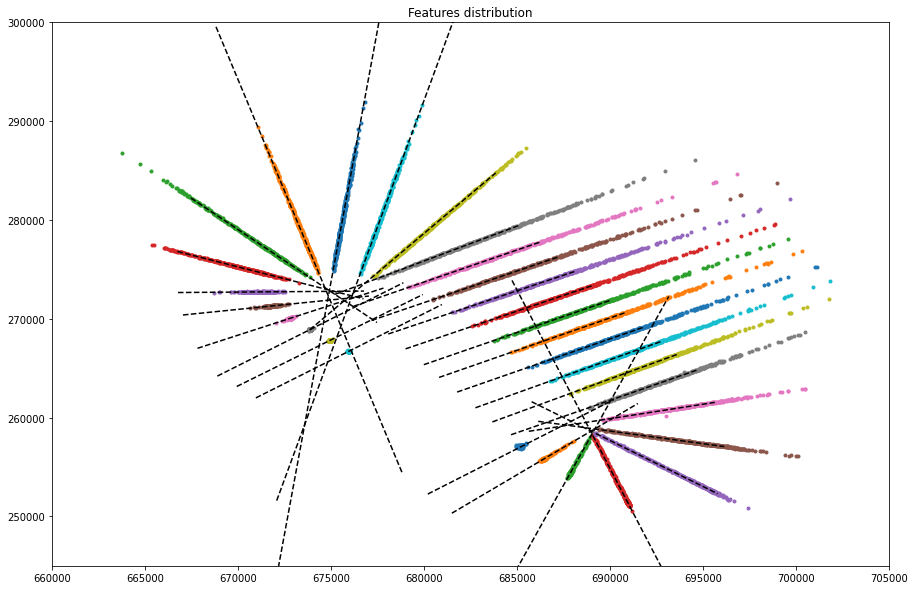

<IPython.core.display.Javascript object>

In [39]:
features = ["x", "y"]
X = np.stack(list(f.data[features].values.ravel() for f in t_GA_resampled))

plt.figure(figsize=(15, 10))

plt.subplot(111)
for i in range(nb_points):
    plt.scatter(X[:, ::2][:, i].T, X[:, 1::2][:, i].T, marker=".")
plt.title("Features distribution")

for ele in perpendiculars:
    y1 = ele[0] * (ele[2] - 5000) + ele[1]
    y2 = ele[0] * (ele[2] + 5000) + ele[1]

    plt.plot(
        [(ele[2] - 5000), (ele[2] + 5000)], [y1, y2], color="black", linestyle="--",
    )

plt.xlim((660000, 705000))
plt.ylim((245000, 300000))
plt.show()

In [36]:
import altair as alt

alt.data_transformers.disable_max_rows()

trajectory = []
for i in range(X.shape[0]):
    trajectory.append(i * np.ones(nb_points))
trajectory = np.array(trajectory).flatten()

point = np.array([range(0, nb_points),] * X.shape[0]).flatten()
test = pd.DataFrame(X[:, ::2].flatten(), columns=["X"])
test["Y"] = X[:, 1::2].flatten()
test["point"] = list(map(str, point))
test["tooltip"] = trajectory

alt.Chart(test).mark_point().encode(
    alt.X("X", scale=alt.Scale(domain=[660000, 705000])),
    alt.Y("Y", scale=alt.Scale(domain=[250000, 300000])),
    alt.Tooltip("tooltip"),
    alt.Color("point"),
).properties(height=600, width=800).interactive()

alt.Chart(...)

<IPython.core.display.Javascript object>